# **Part 2: Data simulation and Analysis** #

## **Emotion estimates**

In [35]:
# ====================================
# 1) SIMULATE DATA (wide format)
# ====================================
# What I am simulating:
# - 3 BETWEEN-subject conditions (1, 2, 3)
# - 10 participants per condition (total N = 30)
# - Each participant gives THREE emotion estimates: angry, happy, neutral
#
# Task constraints (important!):
# - Estimates must sum to 100 (your slider rule: “press space only when total = 100”)
# - Slider increments were 5, so all estimates must be multiples of 5
#
# Expected pattern (based on previous experiments):
# - Angry should be higher overall than Happy and Neutral
# - No systematic differences across conditions (conditions are just “groups” here)

import numpy as np
import pandas as pd

rng = np.random.default_rng(123)  # fixed seed = same simulated dataset every run

n_conditions = 3
n_per_condition = 10

rows = []
participant_id = 1

for condition in range(1, n_conditions + 1):
    for _ in range(n_per_condition):

        # Biased Dirichlet creates underlying probabilities that sum to 1.
        # I weighted Angry higher, so it tends to be larger ON AVERAGE (not always).
        probs = rng.dirichlet([3.0, 1.5, 1.5])  # [Angry, Happy, Neutral]

        # Convert probabilities into 5% increments that sum to 100:
        # - Think of 100% as 20 "chips" worth 5% each.
        # - Multinomial allocates 20 chips across the 3 emotions using probs.
        counts = rng.multinomial(n=20, pvals=probs)  # sums to 20 automatically

        angry, happy, neutral = counts * 5  # now sums to 100; each is a multiple of 5

        rows.append({
            "participant": participant_id,
            "condition": condition,
            "angry": angry,
            "happy": happy,
            "neutral": neutral})

        participant_id += 1

df = pd.DataFrame(rows)

# Sanity checks (catch mistakes immediately)
assert (df[["angry", "happy", "neutral"]].sum(axis=1) == 100).all(), "Some rows do not sum to 100!"
assert ((df[["angry", "happy", "neutral"]] % 5) == 0).all().all(), "Some values are not multiples of 5!"

df.head(30)

,participant,condition,angry,happy,neutral
0,1,1,30,45,25
1,2,1,40,20,40
2,3,1,90,10,0
3,4,1,60,20,20
4,5,1,70,10,20
5,6,1,25,75,0
6,7,1,75,15,10
7,8,1,40,55,5
8,9,1,25,55,20
9,10,1,55,45,0


In [48]:
# ============================================================
# 2) RESHAPE wide → long (for analysis)
# ============================================================
# Why reshape the data?
# - Wide format: one row per participant, separate columns for angry/happy/neutral
# - Long format: one row per *emotion estimate* (3 rows per participant)
# 
# Long format is easier for:
# - repeated-measures tests across emotion
# - grouped summaries for plotting

df_long = df.melt(  # https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.melt.html
    id_vars=["participant", "condition"],          # identifiers for each person
    value_vars=["angry", "happy", "neutral"],      # emotion estimate columns
    var_name="emotion",                            # new column indicating emotion
    value_name="estimate")                         # new column with the numeric estimate

# Make emotion labels look nice (Angry instead of angry)
df_long["emotion"] = df_long["emotion"].str.capitalize()

df_long.head() # Can change the number to 30, 60, 90 to check all data (first 5 rows is cleaner)

,participant,condition,emotion,estimate
0,1,1,Angry,30
1,2,1,Angry,40
2,3,1,Angry,90
3,4,1,Angry,60
4,5,1,Angry,70



MIXED ANOVA (Condition × Emotion) via OLS + subject blocking
                               sum_sq    df             F    PR(>F)
C(condition)             7.573934e-26   2.0  6.927379e-29  1.000000
C(emotion)               1.206500e+04   2.0  1.103506e+01  0.000096
C(participant)           9.500000e+01  29.0  5.992431e-03  1.000000
C(condition):C(emotion)  2.515000e+03   4.0  1.150152e+00  0.343075
Residual                 2.952000e+04  54.0           NaN       NaN

Partial eta squared (ηp²):
C(condition): ηp² = 0.000
C(emotion): ηp² = 0.290
C(condition):C(emotion): ηp² = 0.079

Paired t-tests (collapsed across condition) with Bonferroni correction:
angry vs happy: t = 3.512, p = 0.0015, dz = 0.641, Bonf α = 0.017
angry vs neutral: t = 4.369, p = 0.0001, dz = 0.798, Bonf α = 0.017
happy vs neutral: t = 0.767, p = 0.4494, dz = 0.140, Bonf α = 0.017


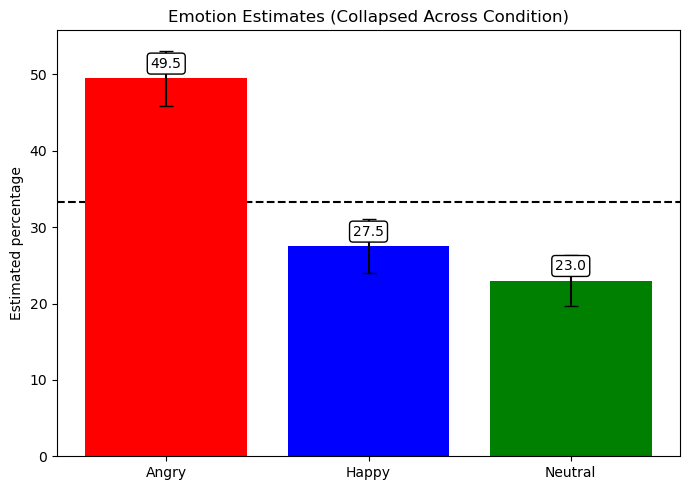

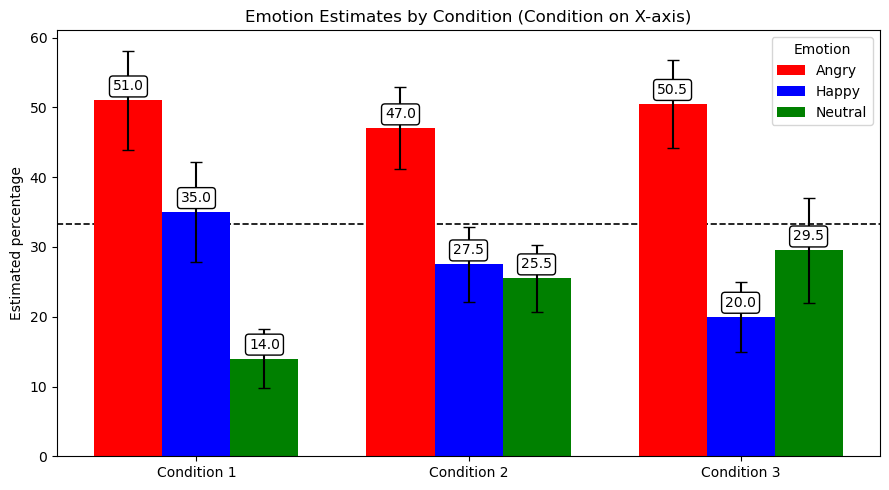

In [52]:
# ============================================================
# 3) ANALYSIS + PLOTTING (MIXED ANOVA + MEAN LABELS ON BARS)
# ============================================================
# What I’m doing here:
# (A) Mixed ANOVA to test CONDITION differences (between-subject), EMOTION differences (within-subject),
#     and the CONDITION × EMOTION interaction (the full “one ANOVA” approach).
# (B) Effect sizes (partial eta squared) so I can report magnitude, not just p-values.
# (C) Follow-up paired t-tests for emotion differences (collapsed across condition), with Bonferroni correction.
# (D) Plot #1: Emotion effect collapsed across condition (Angry=red, Happy=blue, Neutral=green) + mean labels above bars.
# (E) Plot #2: Condition on x-axis (Condition 1/2/3), with colored bars representing emotions + mean labels above bars.
#
# IMPORTANT NUANCE:
# Angry + Happy + Neutral = 100 for EVERY participant (built into the slider rule).
# So the “overall mean across emotions” per participant is always 33.33 and cannot vary across condition.
# That’s why we test CONDITION differences *within each emotion* (via mixed ANOVA structure), not on the overall mean.

import numpy as np                                           # I need numpy for math (sqrt, arrays, etc.)
import pandas as pd                                          # I need pandas for reshaping and summaries
import matplotlib.pyplot as plt                              # I need matplotlib for plotting (assignment-friendly)
import statsmodels.api as sm                                 # statsmodels gives me ANOVA tables from models
from statsmodels.formula.api import ols                      # OLS lets me build the mixed ANOVA with subject blocking
from scipy.stats import ttest_rel                            # paired t-tests for follow-ups (within-subject)
# NOTE: This script assumes, df (wide) and df_long (long) already exist from earlier steps (which it does - see above).

# ------------------------------------------------------------
# (0) QUICK CLEANUP / SAFETY CHECKS (so the rest doesn’t break)
# ------------------------------------------------------------
# I always standardize labels early because “Angry” vs “angry” will silently break pivots/groupbys.

df_long["emotion"] = df_long["emotion"].astype(str).str.lower()     # Force lowercase: angry/happy/neutral
df_long["condition"] = pd.to_numeric(df_long["condition"])          # Make sure condition is numeric (1/2/3)
df_long["participant"] = pd.to_numeric(df_long["participant"])      # Make sure participant is numeric IDs

emotion_order = ["angry", "happy", "neutral"]                       # I set a fixed order so plots/tables are consistent
emotion_colors = {"angry": "red", "happy": "blue", "neutral": "green"}  # Required color mapping from you

# ------------------------------------------------------------
# (A) MIXED ANOVA: Condition (between) × Emotion (within)
# ------------------------------------------------------------
# Why this works:
# - Condition is BETWEEN-subject (different participants per group)
# - Emotion is WITHIN-subject (each participant gives 3 estimates)
# - Participant is included as a blocking factor to account for repeated measures

model = ols(
    "estimate ~ C(condition) * C(emotion) + C(participant)",        # Main effects + interaction + subject blocking
    data=df_long                                                    # long-format data is required here
).fit()                                                             # Fit the model

anova_table = sm.stats.anova_lm(
    model,                                     # The fitted OLS model
    typ=2)                                     # Type II SS is standard for balanced-ish designs


print("\nMIXED ANOVA (Condition × Emotion) via OLS + subject blocking")
print(anova_table)   # shows F-tests for condition, emotion, interaction

# ------------------------------------------------------------
# (B) EFFECT SIZES: Partial Eta Squared (ηp²)
# ------------------------------------------------------------
# Partial eta squared:
# ηp² = SS_effect / (SS_effect + SS_error)
# This tells me the proportion of variance explained by each effect, controlling for the others.

ss_error = anova_table.loc["Residual", "sum_sq"]     # Grab the residual SS once (used repeatedly)

print("\nPartial eta squared (ηp²):")
for effect in ["C(condition)", "C(emotion)", "C(condition):C(emotion)"]:
    ss_effect = anova_table.loc[effect, "sum_sq"]          # SS for that effect
    eta_p2 = ss_effect / (ss_effect + ss_error)            # Compute ηp²
    print(f"{effect}: ηp² = {eta_p2:.3f}")                 # Print out nicely (3 decimals)

# ------------------------------------------------------------
# (C) FOLLOW-UP TESTS: Emotion pairwise comparisons (collapsed)
# ------------------------------------------------------------
# Even if the ANOVA says “emotion matters”, I still need to show the pattern:
# - Is Angry > Happy?
# - Is Angry > Neutral?
# - Is Happy different from Neutral?
#
# Since emotion is within-subject, the correct follow-ups are paired-samples t-tests.
# And because I’m doing 3 tests, I Bonferroni-correct alpha.

wide_em = df_long.pivot(
    index="participant",                                         # One row per person
    columns="emotion",                                           # Columns become angry/happy/neutral
    values="estimate")                                           # Values are the emotion estimates


angry = wide_em["angry"]                                         # angry estimate vector
happy = wide_em["happy"]                                         # happy estimate vector
neutral = wide_em["neutral"]                                     # neutral estimate vector

tests = [
    ("angry vs happy", ttest_rel(angry, happy)),                     # paired because SAME people
    ("angry vs neutral", ttest_rel(angry, neutral)),
    ("happy vs neutral", ttest_rel(happy, neutral))]

alpha_bonf = 0.05 / 3                                                # Bonferroni alpha for 3 comparisons

print("\nPaired t-tests (collapsed across condition) with Bonferroni correction:")
for label, res in tests:
    dz = res.statistic / np.sqrt(len(angry))    # Cohen’s dz for paired designs (simple + common)
    print(f"{label}: t = {res.statistic:.3f}, p = {res.pvalue:.4f}, dz = {dz:.3f}, Bonf α = {alpha_bonf:.3f}")

# ------------------------------------------------------------
# (D) DESCRIPTIVES FOR PLOT #1 (collapsed across condition)
# ------------------------------------------------------------
# For the bar plot, I need mean and SE for each emotion, collapsed across condition.
# NOTE: SE = SD / sqrt(N). Here N is the number of observations at that emotion level (participants).

emotion_summary = (
    df_long
    .groupby("emotion", as_index=False, observed=True)               # Group only by emotion (ignore condition)
    .agg(mean=("estimate", "mean"),                                  # Bar height
         sd=("estimate", "std"),                                     # Variability
         n=("estimate", "count")))                                   # Sample size

emotion_summary["se"] = emotion_summary["sd"] / np.sqrt(emotion_summary["n"])  # Standard error for error bars

emotion_summary["emotion"] = pd.Categorical(         # Force a consistent bar order
    emotion_summary["emotion"], categories=emotion_order, ordered=True)

emotion_summary = emotion_summary.sort_values("emotion")     # Sort so the bars appear angry/happy/neutral

# ------------------------------------------------------------
# Helper function: Add the mean labels above bars (boxed)
# ------------------------------------------------------------
# I’m making this a function so I can reuse it for BOTH plots without rewriting code.

def add_mean_labels(ax, bars, values, y_offset=1.0):           # ax = plot axis; bars = bar objects; values = means
    for bar, val in zip(bars, values):                         # loop through each bar and its mean
        ax.text(
            bar.get_x() + bar.get_width() / 2,                 # x = center of bar
            bar.get_height() + y_offset,                       # y = just above top of bar
            f"{val:.1f}",                                      # Show 1 decimal place (clean + readable)
            ha="center", va="bottom",                          # Centered above bar
            fontsize=10,                                       # Readable but not huge
            bbox=dict(boxstyle="round,pad=0.25", facecolor="white", edgecolor="black"))  # the “boxed” label look
        
# ------------------------------------------------------------
# (E) PLOT #1: Emotion effect (collapsed across condition)
# ------------------------------------------------------------
# Requirements:
# - Angry = red, Happy = blue, Neutral = green
# - Add a 33.33% reference line (black) BEHIND the bars
# - Put mean boxes above each bar

fig, ax = plt.subplots(figsize=(7, 5))                      # Make a figure + axis (gives me more control than plt.*)

x = np.arange(len(emotion_summary))                         # x positions for 3 bars

bar_colors = [emotion_colors[e] for e in emotion_summary["emotion"]] # Color list in correct order

ax.axhline(
    100/3,                                                    # 33.33% reference line
    color="black", linestyle="--", linewidth=1.5,             # Black dashed line
    zorder=0)                                                 # zorder=0 forces it BEHIND everything else

bars = ax.bar(
    x,
    emotion_summary["mean"],                                  # Bar heights
    yerr=emotion_summary["se"],                               # SE error bars
    capsize=5,
    color=bar_colors,                                         # Angry/happy/neutral colors
    zorder=2)                                                 # Bars above the line

ax.set_xticks(x)                                                     # Set tick positions
ax.set_xticklabels([e.title() for e in emotion_summary["emotion"]])  # label ticks as Angry/Happy/Neutral
ax.set_ylabel("Estimated percentage")                                # y-axis label
ax.set_title("Emotion Estimates (Collapsed Across Condition)")       # Plot title

add_mean_labels(                                                     # Add mean boxes above each bar
    ax=ax,
    bars=bars,
    values=emotion_summary["mean"].values,
    y_offset=1.0)                                                    # How far above the bar the label sits

fig.tight_layout()                                                   # Prevents labels/titles from getting cut off
plt.show()                                                           # Display plot

# ------------------------------------------------------------
# (F) DESCRIPTIVES FOR PLOT #2 (condition on x-axis)
# ------------------------------------------------------------
# What I need specifically:
# - Condition should be the x-axis
# - Bar colors should match Figure 1 (emotion colors)
# - Means should be shown above each bar again
#
# So for each condition, I want 3 bars: angry/happy/neutral.

emotion_by_condition = (
    df_long
    .groupby(["condition", "emotion"], as_index=False, observed=True) # Group by condition AND emotion
    .agg(mean=("estimate", "mean"),
         sd=("estimate", "std"),
         n=("estimate", "count")))

emotion_by_condition["se"] = emotion_by_condition["sd"] / np.sqrt(emotion_by_condition["n"])  # SE for error bars

conditions = sorted(df_long["condition"].unique())                    # Ensure order 1,2,3
x0 = np.arange(len(conditions))                                       # Base x positions for each condition group
bar_width = 0.25                                                      # Width for each emotion bar within a condition

# ------------------------------------------------------------
# (G) PLOT #2: Condition on x-axis, emotion bars within condition
# ------------------------------------------------------------

fig, ax = plt.subplots(figsize=(9, 5))                                # Wider because grouped bars need more space

ax.axhline(
    100/3,                                                            # 33.33% reference line again (same logic)
    color="black", linestyle="--", linewidth=1.2,
    zorder=0)                                                         # Behind bars

# I loop through emotions so I can:
# - keep the color mapping consistent
# - make the legend be emotion-based (which matches your first plot)

all_means_for_labels = []                                             # I store means in plotting order so labels match bars
all_bars_for_labels = []                                              # I store bar objects so I can label them after

for i, emo in enumerate(emotion_order):                                # loop in the order angry/happy/neutral
    sub = (
        emotion_by_condition[emotion_by_condition["emotion"] == emo]   # Keep only this emotion
        .set_index("condition")                                        # Index by condition so I can align properly
        .loc[conditions])                                              # Enforce condition ordering 1,2,3

    x_pos = x0 + (i - 1) * bar_width                                   # Shift: angry left, happy center, neutral right

    bars = ax.bar(
        x_pos,
        sub["mean"].values,                                            # Bar heights
        yerr=sub["se"].values,                                         # Error bars
        width=bar_width,
        capsize=4,
        color=emotion_colors[emo],                                     # Same colors as plot #1
        label=emo.title(),                                             # Legend label
        zorder=2)                                                      # Bars above the line

    all_bars_for_labels.extend(bars)                                   # Keep these bar objects for labeling
    all_means_for_labels.extend(sub["mean"].values)                    # Keep corresponding means

ax.set_xticks(x0)                                                      # Tick locations at each condition group
ax.set_xticklabels([f"Condition {c}" for c in conditions])             # x-axis labels
ax.set_ylabel("Estimated percentage")                                  # y-axis label
ax.set_title("Emotion Estimates by Condition (Condition on X-axis)")   # Title (exactly what this figure shows)
ax.legend(title="Emotion")                                             # Legend clarifies colors = emotions

add_mean_labels(                                                       # Add mean boxes above every single bar
    ax=ax,
    bars=all_bars_for_labels,
    values=np.array(all_means_for_labels),
    y_offset=1.0)

fig.tight_layout()                                                     # Keep layout clean
plt.show()                                                             # Display plot                      

### **Results:**
- A mixed ANOVA with condition as a between-subject factor and emotion as a within-subject factor was conducted.

- It revealed no main effect of condition, indicating that overall emotion estimates did not differ across conditions.

- There was a significant main effect of emotion, with participants estimating angry faces as more frequent than happy or neutral faces.

- The condition × emotion interaction was not significant, indicating that the emotion-estimation pattern was consistent across conditions.

- Follow-up paired-samples t-tests (Bonferroni-corrected) showed that angry estimates were significantly higher than both happy and neutral estimates, while happy and neutral estimates did not differ.


### **Sources:**

- **NumPy – Random Sampling & Numerical Operations**  
  https://numpy.org/doc/stable/  
  Used for random number generation, numerical operations, and standard error calculations in the simulation and analysis steps.

- **Pandas – Data Reshaping & Aggregation**  
  https://pandas.pydata.org/docs/  
  Used for reshaping data between wide and long formats, grouping by condition and emotion, and computing descriptive statistics.

- **SciPy – Statistical Tests**  
  https://docs.scipy.org/doc/scipy/reference/stats.html  
  Used for one-way ANOVAs (`f_oneway`) and paired-samples t-tests (`ttest_rel`) when examining condition and emotion effects.

- **Statsmodels – Mixed / Repeated-Measures ANOVA**  
  https://www.statsmodels.org/stable/anova.html  
  https://www.statsmodels.org/stable/generated/statsmodels.stats.anova.AnovaRM.html  
  Used to implement repeated-measures and mixed-design ANOVAs with participant-level blocking.

- **Effect Sizes (Partial Eta Squared)**  
  https://statistics.laerd.com/statistical-guides/partial-eta-squared.php  
  Used to quantify the proportion of variance explained by emotion, condition, and their interaction in ANOVA designs.

- **Matplotlib – Bar Plots & Error Bars**  
  https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.bar.html  
  https://matplotlib.org/stable/gallery/statistics/barchart_demo.html  
  Used for plotting mean emotion estimates, standard error bars, reference lines, and grouped condition visualizations.


## **Memory data**

In [99]:
# ============================================================
# 1) SIMULATION: MEMORY TASK DATA + SDT METRICS (d′ and C)
# ============================================================
# What I’m simulating here:
# - Each participant completes 54 memory trials total:
#     • 36 OLD (previously seen) faces
#     • 18 NEW (foil) faces
# - The stimuli are evenly split across emotion:
#     • OLD: 12 Angry, 12 Happy, 12 Neutral
#     • NEW:  6 Angry,  6 Happy,  6 Neutral
#
# What I WANT the simulation to reflect (based on my past studies):
# - No memory advantage for angry faces (so d′ should be similar across emotions)
# - Criterion (C) should also be similar across emotions (no systematic bias)
#
# What this code outputs:
# - A long-format trial-level dataset (like my CSV idea)
# - A summary dataset with Hit rate, FA rate, d′, and C per emotion per participant

import numpy as np                                      # I use numpy for random sampling + math
import pandas as pd                                     # I use pandas to organize the simulated dataset
from scipy.stats import norm                            # norm.ppf = inverse normal CDF (needed for d′ and C)

rng = np.random.default_rng(42)                         # Fixed seed so my simulation is reproducible (same results every run)

# -------------------------
# BASIC STUDY DESIGN CHOICES
# -------------------------
n_participants = 30                                     # Total participants I want in the simulated dataset
emotions = ["angry", "happy", "neutral"]                # Within-subject factor levels

n_old_per_emotion = 12                                  # OLD faces per emotion (12×3 = 36 old)
n_new_per_emotion = 6                                   # NEW foils per emotion (6×3 = 18 new)

# -------------------------
# TARGET MEMORY PERFORMANCE
# -------------------------
# I’m setting "true" hit and false alarm rates that are roughly equal across emotions. This avoids building in a fake angry advantage.
# Important: These are NOT the observed rates—these are "probabilities" used to generate responses.

hit_rate_target = {                                     # Probability of saying YES when OLD (hit)
    "angry": 0.70,
    "happy": 0.70,
    "neutral": 0.70}

fa_rate_target = {                                      # Probability of saying YES when NEW (false alarm)
    "angry": 0.25,
    "happy": 0.25,
    "neutral": 0.25}

# -------------------------
# SIMULATING TRIAL-LEVEL ROWS
# -------------------------
rows_trials = []                                        # I will store each memory trial here (one row per trial)

for pid in range(1, n_participants + 1):                # Loop through participants one by one

    # Small person-to-person variability (so not everyone has identical memory)
    # I’m adding a tiny random shift in performance that applies across emotions.
    person_shift = rng.normal(loc=0.0, scale=0.03)      # Small shift (± a few %) — feels realistic

    for emo in emotions:                                # Loop through emotions

        # -------------------------
        # SIMULATE OLD TRIALS (HITS)
        # -------------------------
        # OLD trials: correct response is YES.
        # I simulate whether each old trial gets a YES (hit) vs NO (miss).
        p_hit = np.clip(hit_rate_target[emo] + person_shift, 0.01, 0.99)   # Clip avoids impossible probabilities

        for t in range(n_old_per_emotion):              # Make 12 old trials for this emotion
            response_yes = rng.binomial(n=1, p=p_hit)   # 1 = YES, 0 = NO (Bernoulli trial)
            old = 1                                     # I code OLD = 1 (seen previously)

            correct = int(response_yes == 1)            # If it's old, YES is correct (so response should be 1)

            rows_trials.append({                        # Store trial row (similar structure to my memory output)
                "participant": pid,
                "emotion": emo,
                "old": old,
                "response_yes": response_yes,
                "correct": correct})

        # -------------------------
        # SIMULATE NEW TRIALS (FALSE ALARMS)
        # -------------------------
        # NEW trials: correct response is NO.
        # A "false alarm" happens when they say YES to a new face.
        p_fa = np.clip(fa_rate_target[emo] + person_shift, 0.01, 0.99)     # Again, clip to stay in bounds

        for t in range(n_new_per_emotion):              # Make 6 new trials for this emotion
            response_yes = rng.binomial(n=1, p=p_fa)    # 1 = YES (false alarm), 0 = NO (correct rejection)
            old = 0                                     # I code NEW/FOIL = 0

            correct = int(response_yes == 0)            # If it's new, NO is correct (so response should be 0)

            rows_trials.append({
                "participant": pid,
                "emotion": emo,
                "old": old,
                "response_yes": response_yes,
                "correct": correct})

# Convert trial list into a DataFrame
df_trials = pd.DataFrame(rows_trials)                   # This is my full simulated "memory task" dataset

# -------------------------
# FUNCTION: COMPUTE SDT METRICS SAFELY
# -------------------------
# d′ needs z(H) - z(FA)
# C needs -0.5 * (z(H) + z(FA))
#
# Big problem: if H=1.0 or FA=0.0, norm.ppf breaks (infinite z).
# So I apply the "loglinear correction":
#   hit_rate = (hits + 0.5) / (n_old + 1)
#   fa_rate  = (fa + 0.5)   / (n_new + 1)

def compute_dprime_c(hits, misses, fas, crs):
    n_old = hits + misses                               # Total old trials
    n_new = fas + crs                                   # Total new trials

    hit_rate = (hits + 0.5) / (n_old + 1.0)             # Corrected hit rate (avoids 0 or 1)
    fa_rate  = (fas  + 0.5) / (n_new + 1.0)             # Corrected FA rate (avoids 0 or 1)

    zH = norm.ppf(hit_rate)                              # Convert hit rate to z-score
    zF = norm.ppf(fa_rate)                               # Convert FA rate to z-score

    d_prime = zH - zF                                    # Sensitivity (higher = better discrimination)
    criterion = -0.5 * (zH + zF)                         # Bias (positive = conservative, negative = liberal)

    return hit_rate, fa_rate, d_prime, criterion         # Return all values so I can store them

# -------------------------
# SUMMARIZE TO PARTICIPANT × EMOTION
# -------------------------
rows_summary = []                                        # This will store one row per participant per emotion

for (pid, emo), sub in df_trials.groupby(["participant", "emotion"]):  # Group trials by participant and emotion

    hits   = int(((sub["old"] == 1) & (sub["response_yes"] == 1)).sum())  # YES on OLD
    misses = int(((sub["old"] == 1) & (sub["response_yes"] == 0)).sum())  # NO on OLD
    fas    = int(((sub["old"] == 0) & (sub["response_yes"] == 1)).sum())  # YES on NEW
    crs    = int(((sub["old"] == 0) & (sub["response_yes"] == 0)).sum())  # NO on NEW

    hit_rate, fa_rate, d_prime, criterion = compute_dprime_c(hits, misses, fas, crs)  # Compute SDT metrics

    rows_summary.append({
        "participant": str(pid),                          # I store as string because statsmodels likes categorical subject IDs
        "emotion": emo,
        "hits": hits,
        "misses": misses,
        "fas": fas,
        "crs": crs,
        "hit_rate": hit_rate,
        "fa_rate": fa_rate,
        "d_prime": d_prime,
        "criterion": criterion})

df_sdt = pd.DataFrame(rows_summary)                      # Final SDT summary dataset (used for ANOVAs + plots)

# Quick checks (optional but helpful)
print("Trial-level dataset shape:", df_trials.shape)     # Should be n_participants × 54 rows
print("SDT summary dataset shape:", df_sdt.shape)        # Should be n_participants × 3 rows
df_sdt.head(6) # First two participants to keep it clean/short

Trial-level dataset shape: (1620, 5)
SDT summary dataset shape: (90, 10)


,participant,emotion,hits,misses,fas,crs,hit_rate,fa_rate,d_prime,criterion
0,1,angry,7,5,2,4,0.576923,0.357143,0.560134,0.086039
1,1,happy,7,5,1,5,0.576923,0.214286,0.985667,0.298805
2,1,neutral,9,3,1,5,0.730769,0.214286,1.406780,0.088249
3,2,angry,11,1,1,5,0.884615,0.214286,1.990018,-0.203371
4,2,happy,10,2,0,6,0.807692,0.071429,2.334658,0.297905
5,2,neutral,8,4,2,4,0.653846,0.357143,0.761832,-0.014809



Repeated-measures ANOVA on d′
                Anova
        F Value Num DF  Den DF Pr > F
-------------------------------------
emotion  0.3146 2.0000 58.0000 0.7313


Repeated-measures ANOVA on Criterion (C)
                Anova
        F Value Num DF  Den DF Pr > F
-------------------------------------
emotion  0.5251 2.0000 58.0000 0.5943


----------------------------
Effect sizes (partial η²)
----------------------------
d′ emotion effect:        ηp² = 0.011
Criterion emotion effect: ηp² = 0.018


C:\Users\tinne\AppData\Local\Temp\ipykernel_5504\414535322.py:107: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("emotion", as_index=False)                                    # Collapse across participants within emotion


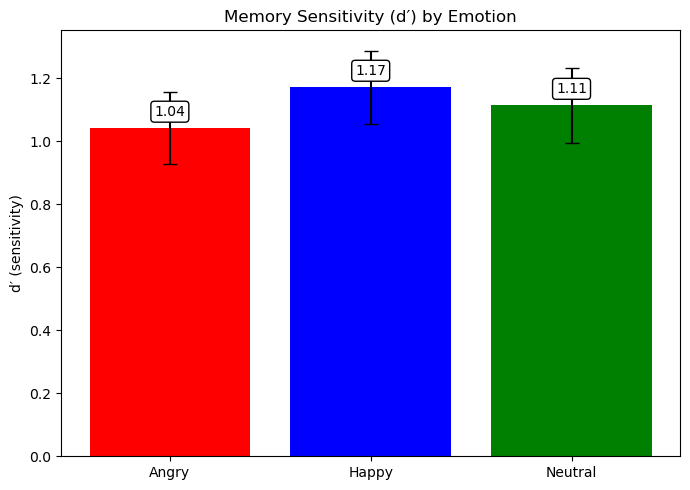

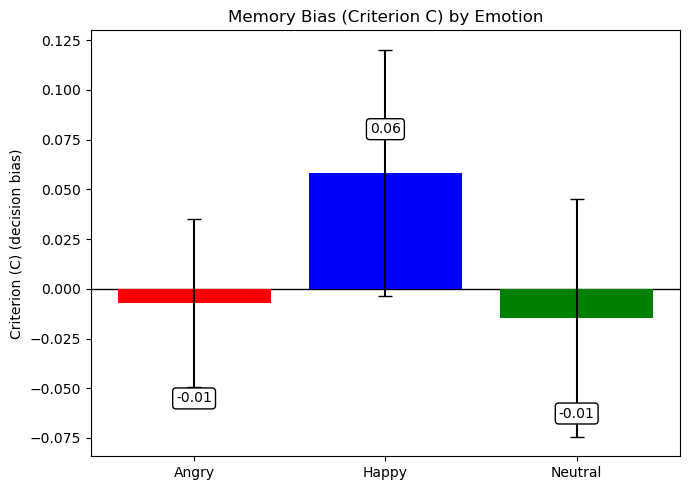

In [100]:
# ============================================================
# 2) ANALYSIS + PLOTTING: RM ANOVAs ON d′ AND C + EFFECT SIZES
# ============================================================
# What I’m doing here:
# (A) Run a repeated-measures ANOVA on d′ (emotion as within-subject)
# (B) Run a repeated-measures ANOVA on criterion C (emotion as within-subject)
# (C) Compute effect sizes (partial eta squared) for BOTH
# (D) Plot means + SE with colored bars + mean labels
#
# What I expect (based on my studies):
# - No emotion differences in memory → d′ should be similar across angry/happy/neutral
# - No emotion differences in bias → C should be similar too

import numpy as np                                      # Used for x-axis positions and SE math
import pandas as pd                                     # Used for grouping + summaries
import matplotlib.pyplot as plt                          # Used for plotting
from statsmodels.stats.anova import AnovaRM              # Repeated-measures ANOVA

# -------------------------
# BASIC CLEANING / SAFETY
# -------------------------
# statsmodels is picky, so I standardize emotion labels and participant IDs again
df_sdt["emotion"] = df_sdt["emotion"].astype(str).str.lower().str.strip()  # Keeps factor levels clean and consistent
df_sdt["participant"] = df_sdt["participant"].astype(str)                  # Must be categorical ID

# I also choose a fixed plotting order so graphs don’t shuffle emotions randomly
emotion_order = ["angry", "happy", "neutral"]                               # My standard order
df_sdt["emotion"] = pd.Categorical(df_sdt["emotion"], categories=emotion_order, ordered=True)  # Forces order

# I want the same colors as my earlier graphs
emotion_colors = {"angry": "red", "happy": "blue", "neutral": "green"}      # Matching my emotion palette

# -------------------------
# (A) RM ANOVA ON d′
# -------------------------
# This is a within-subject ANOVA because:
# - Each participant contributes one d′ per emotion
# - So we are comparing emotion means while controlling for individual differences

aov_d = AnovaRM(
    data=df_sdt,                                      # Long-format dataset
    depvar="d_prime",                                  # Dependent variable = sensitivity
    subject="participant",                              # Repeated-measures ID (blocks the participant variance)
    within=["emotion"]                                  # Within-subject factor (emotion)
).fit()

print("\n==============================")
print("Repeated-measures ANOVA on d′")
print("==============================")
print(aov_d)

# -----------------------------
# (B) RM ANOVA ON Criterion (C)
# -----------------------------
# Same logic as above, but now DV = criterion (decision bias)

aov_c = AnovaRM(
    data=df_sdt,
    depvar="criterion",
    subject="participant",
    within=["emotion"]
).fit()

print("\n=======================================")
print("Repeated-measures ANOVA on Criterion (C)")
print("=======================================")
print(aov_c)

# --------------------------------------
# EFFECT SIZE: PARTIAL ETA SQUARED (ηp²) 
# --------------------------------------
# My AnovaRM table DOES NOT include Sum of Squares.
# It only gives F and the dfs, so I compute partial η² from:
# ηp² = (F * df_effect) / (F * df_effect + df_error)

def partial_eta_sq_from_F(anova_table, effect_name="emotion"):
    # anova_table is the statsmodels AnovaRM table (a pandas DataFrame)
    # effect_name is the row label (usually "emotion")

    F = anova_table.loc[effect_name, "F Value"]           # Grab the F statistic for the effect
    df_effect = anova_table.loc[effect_name, "Num DF"]    # Numerator df (effect df)
    df_error  = anova_table.loc[effect_name, "Den DF"]    # Denominator df (error df)

    eta_p2 = (F * df_effect) / (F * df_effect + df_error) # Partial eta squared formula

    return float(eta_p2)                                  # Make it a plain Python float for clean printing


# Compute ηp² for emotion effect on d′ and on criterion
eta_d = partial_eta_sq_from_F(aov_d.anova_table, "emotion")  # d′ emotion effect size
eta_c = partial_eta_sq_from_F(aov_c.anova_table, "emotion")  # Criterion emotion effect size

print("\n----------------------------")
print("Effect sizes (partial η²)")
print("----------------------------")
print(f"d′ emotion effect:        ηp² = {eta_d:.3f}")
print(f"Criterion emotion effect: ηp² = {eta_c:.3f}")

# -------------------------
# (D) DESCRIPTIVES FOR PLOTTING (MEAN + SE)
# -------------------------
# I compute mean and standard error for each emotion.
# SE = SD / sqrt(N), using ddof=1 to get sample SD.

summary = (
    df_sdt
    .groupby("emotion", as_index=False)                                    # Collapse across participants within emotion
    .agg(
        mean_d=("d_prime", "mean"),                                        # Mean d′ per emotion
        sd_d=("d_prime", "std"),                                           # SD d′ per emotion
        mean_c=("criterion", "mean"),                                      # Mean criterion per emotion
        sd_c=("criterion", "std"),                                         # SD criterion per emotion
        n=("participant", "count")))                                       # N participants contributing to each mean

summary["se_d"] = summary["sd_d"] / np.sqrt(summary["n"])                  # Standard error for d′
summary["se_c"] = summary["sd_c"] / np.sqrt(summary["n"])                  # Standard error for criterion

summary = summary.sort_values("emotion")                                    # Enforces angry/happy/neutral plotting order

# ----------------------------------------
# HELPER: ADD MEAN LABEL BOXES ABOVE BARS
# ---------------------------------------
# I’m doing this because it makes the graph “readable at a glance” in an assignment report.

def label_bars(bars, values, y_offset=0.03):
    for bar, val in zip(bars, values):
        x = bar.get_x() + bar.get_width() / 2                               # Center label above the bar
        y = bar.get_height() + y_offset                                     # Put label slightly above bar height
        plt.text(
            x, y,
            f"{val:.2f}",                                                   # Rounded mean value text
            ha="center", va="bottom",
            bbox=dict(boxstyle="round,pad=0.25", fc="white", ec="black", lw=1))  # White box with black border
        
# -------------------------
# (E) PLOT 1: d′ BY EMOTION
# -------------------------
plt.figure(figsize=(7, 5))                                                 # Create a single plot (no subplots)

x = np.arange(len(summary["emotion"]))                                      # x positions for the 3 emotions
bar_colors = [emotion_colors[e] for e in summary["emotion"]]                # Map emotion names to bar colors

bars = plt.bar(
    x,
    summary["mean_d"],                                                       # Bar heights = mean d′
    yerr=summary["se_d"],                                                    # Error bars = SE
    capsize=5,
    color=bar_colors)

plt.xticks(x, [e.title() for e in summary["emotion"]])                       # Nice labels: Angry/Happy/Neutral
plt.ylabel("d′ (sensitivity)")                                               # y-axis label
plt.title("Memory Sensitivity (d′) by Emotion")                              # Plot title

label_bars(bars, summary["mean_d"].values, y_offset=0.03)                    # Add mean value boxes above bars

plt.tight_layout()                                                           # Avoid label cutoff
plt.show()                                                                   # Display plot

# --------------------------------------
# (F) PLOT 2: Criterion (C) BY EMOTION
# --------------------------------------
plt.figure(figsize=(7, 5))                                                   # New figure for criterion

bars = plt.bar(
    x,
    summary["mean_c"],                                                       # Bar heights = mean criterion
    yerr=summary["se_c"],                                                    # Error bars = SE
    capsize=5,
    color=bar_colors)

plt.axhline(0, color="black", linewidth=1, zorder=0)                         # Reference line at 0 bias (behind bars)

plt.xticks(x, [e.title() for e in summary["emotion"]])                       # Same x labels
plt.ylabel("Criterion (C) (decision bias)")                                  # y-axis label
plt.title("Memory Bias (Criterion C) by Emotion")                            # Plot title

# For criterion, labels can overlap if values are negative, so I offset based on direction
for bar, val in zip(bars, summary["mean_c"].values):
    x_mid = bar.get_x() + bar.get_width() / 2
    y = bar.get_height() + (0.02 if val >= 0 else -0.05)                     # Push label above positive bars, below negative bars
    plt.text(
        x_mid, y,
        f"{val:.2f}",
        ha="center",
        bbox=dict(boxstyle="round,pad=0.25", fc="white", ec="black", lw=1))

plt.tight_layout()
plt.show()

### **Results:**

- I examined whether recognition memory performance differed across emotional expressions (angry, happy, neutral). 

- Memory sensitivity (d′) and response bias (C) were computed separately for each emotion and analyzed using repeated-measures ANOVAs with emotion as a within-participant factor.

#### **Memory Sensitivity (d′):**

- A repeated-measures ANOVA revealed **no significant main effect of emotion on d′**, *F*(2, 58) = 0.31, *p* = .73, η²ₚ = .011.

- As shown in Figure 1, mean sensitivity values were highly similar across emotions (Angry ≈ 1.04, Happy ≈ 1.17, Neutral ≈ 1.11), with overlapping standard error bars.

- This indicates that participants were **no more sensitive to angry faces than to happy or neutral faces** in recognition memory.

#### **Response Bias (C):**

- A repeated-measures ANOVA on criterion C also revealed **no significant effect of emotion**, *F*(2, 58) = 0.53, *p* = .59, η²ₚ = .018.

- Criterion values were close to zero for all emotions (Angry ≈ −0.01, Happy ≈ 0.06, Neutral ≈ −0.01), indicating **minimal response bias** and no systematic tendency to respond more liberally or conservatively for any specific emotion category.

#### **Summary:**

- Together, these findings indicate that **emotional expression did not influence recognition memory sensitivity or decision bias**. 

- Despite robust emotional effects in frequency estimation tasks, **memory performance itself remained emotion-invariant**, consistent with prior studies in this research program showing no memory advantage for angry faces.


### **References:**

#### **Signal Detection Theory (d′ and Criterion)**
- Macmillan, N. A., & Creelman, C. D. (2005). *Detection theory: A user’s guide* (2nd ed.). Lawrence Erlbaum.
- Stanislaw, H., & Todorov, N. (1999). Calculation of signal detection theory measures. *Behavior Research Methods*, 31, 137–149.

#### **Python: Simulation & Numerical Methods**
- **NumPy Random Generator**  
  https://numpy.org/doc/stable/reference/random/generator.html
- **NumPy Multinomial Distribution**  
  https://numpy.org/doc/stable/reference/random/generated/numpy.random.Generator.multinomial.html

#### **Python: Data Handling**
- **pandas DataFrame & GroupBy**  
  https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.groupby.html
- **pandas reshaping (wide ↔ long formats)**  
  https://pandas.pydata.org/docs/user_guide/reshaping.html

#### **Python: Statistical Analysis**
- **statsmodels Repeated-Measures ANOVA (`AnovaRM`)**  
  https://www.statsmodels.org/stable/anova.html
- **SciPy statistical tests**  
  https://docs.scipy.org/doc/scipy/reference/stats.html

#### **Python: Plotting**
- **Matplotlib bar plots**  
  https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.bar.html
- **Error bars in Matplotlib**  
  https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.errorbar.html


## **Emotion ratings**

In [105]:
# ============================================================
# SIMULATION: EMOTION RATINGS TASK
# ============================================================
# Conceptual overview:
# - This simulates the FINAL task in the experiment (emotion ratings)
# - Participants rate ONLY the 36 OLD faces they previously saw
# - There are exactly 12 faces per emotion (angry, neutral, happy)
# - Ratings are on a discrete 1–9 scale:
#       1 = very positive
#       5 = neutral
#       9 = very negative
#
# Critically:
# - There is NO condition variable here
# - Emotion is the only factor of interest
# - Emotion is a WITHIN-subject factor (each participant rates all emotions)

import numpy as np                 # Used for random sampling and numeric operations
import pandas as pd                # Used to store and organize simulated data in tables

rng = np.random.default_rng(123)   # Fixed random seed so the simulation is reproducible
                                   # This is important for assignments and debugging

n_participants = 30                # Total number of simulated participants
faces_per_emotion = 12             # Each participant rates 12 faces per emotion

rows = []                          # Empty list that will store every simulated rating
                                   # Each entry will later become one row in the DataFrame

for pid in range(1, n_participants + 1):
    # Loop through participants one at a time
    # pid serves as a simple participant ID (1–30)

    # ------------------------------------------------
    # Simulating ratings for each emotion separately
    # ------------------------------------------------
    # I do this separately (rather than all at once) so I can:
    # - Explicitly impose the expected theoretical ordering
    # - Angry = most negative
    # - Neutral = middle
    # - Happy = least negative

    angry = rng.normal(
        loc=7.5,                   # Mean close to the negative end of the scale
        scale=0.8,                 # Some variability, but not extreme
        size=faces_per_emotion)    # 12 angry faces

    neutral = rng.normal(
        loc=5.0,                   # Centered exactly at the neutral midpoint
        scale=0.6,                 # Slightly tighter distribution
        size=faces_per_emotion)    # 12 neutral faces

    happy = rng.normal(
        loc=2.5,                   # Low values = positive end of the scale
        scale=0.8,                 # Comparable variability to angry
        size=faces_per_emotion)    # 12 happy faces

    # ------------------------------------------------
    # Enforcing task constraints
    # ------------------------------------------------
    # In the real experiment:
    # - Participants can ONLY select integers
    # - Ratings MUST fall between 1 and 9
    #
    # Therefore, I:
    # 1) Round values to the nearest integer
    # 2) Clip values so nothing falls outside [1, 9]

    angry   = np.clip(np.round(angry),   1, 9)
    neutral = np.clip(np.round(neutral), 1, 9)
    happy   = np.clip(np.round(happy),   1, 9)

    # ------------------------------------------------
    # Storing the data in LONG format
    # ------------------------------------------------
    # Long format is essential because:
    # - Repeated-measures ANOVA expects one row per observation
    # - Each face rating is treated as a separate observation
    #
    # Columns:
    # - participant: who gave the rating
    # - emotion: which emotion category the face belonged to
    # - rating: the 1–9 negativity rating

    for r in angry:
        rows.append({
            "participant": pid,     # Participant ID
            "emotion": "angry",     # Emotion category
            "rating": r})           # Discrete rating value

    for r in neutral:
        rows.append({
            "participant": pid,
            "emotion": "neutral",
            "rating": r})

    for r in happy:
        rows.append({
            "participant": pid,
            "emotion": "happy",
            "rating": r})

# Convert the list of dictionaries into a Pandas DataFrame
# This is the object that will be used for all analysis and plotting
df_ratings = pd.DataFrame(rows)

# Quick sanity check:
# - Confirms the structure looks correct before moving on
df_ratings.head()

,participant,emotion,rating
0,1,angry,7.0
1,1,angry,7.0
2,1,angry,9.0
3,1,angry,8.0
4,1,angry,8.0



Repeated-measures ANOVA (Emotion):
                 Anova
         F Value  Num DF  Den DF Pr > F
---------------------------------------
emotion 1116.6602 2.0000 58.0000 0.0000


Statsmodels not available or AnovaRM failed.
Error: 'Sum Sq'
I can still do planned comparisons with paired t-tests below (that part will still run).

Planned comparisons (paired t-tests):
Bonferroni-corrected alpha = 0.017

Angry vs Happy: t(29) = 48.805, p = 0.0000, dz = 8.911, mean diff = 4.83
Angry vs Neutral: t(29) = 24.984, p = 0.0000, dz = 4.561, mean diff = 2.56
Neutral vs Happy: t(29) = 21.553, p = 0.0000, dz = 3.935, mean diff = 2.26


C:\Users\tinne\AppData\Local\Temp\ipykernel_5504\1609448475.py:174: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("emotion", as_index=False)                                              # Collapse across participants


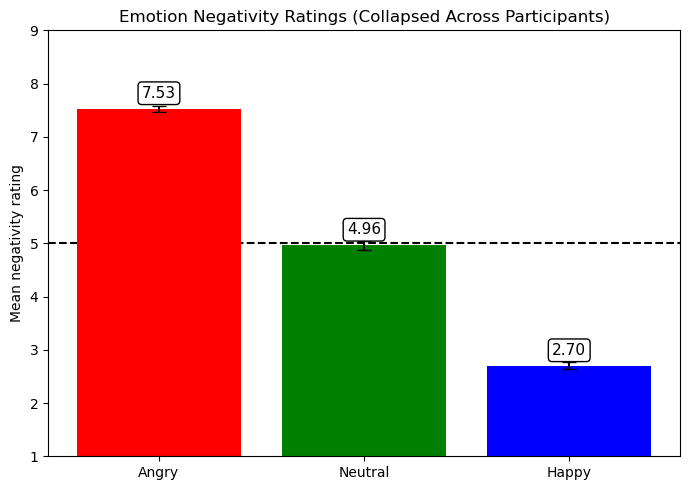

In [111]:
# ============================================================
# EMOTION RATINGS TASK + PLANNED COMPARISONS
# ============================================================
# What this code does:
# 1) Simulate ratings for 30 participants (36 OLD faces total per participant)
#    - 12 angry, 12 neutral, 12 happy (equal counts)
#    - Scale: 1 = very positive, 5 = neutral, 9 = very negative
#    - Expected pattern from my past studies: Angry highest, Neutral middle, Happy lowest
# 2) Compute participant-level means per emotion (so each person contributes 3 means)
# 3) Run a repeated-measures ANOVA (within-subject factor = emotion)
# 4) Run PLANNED COMPARISONS (paired t-tests) with an error-rate correction
# 5) Plot means with different colors + neutral midpoint line BEHIND the bars + mean labels above bars

import numpy as np                           # I need numpy for simulation + basic math
import pandas as pd                          # I need pandas to organize the simulated dataset + compute means cleanly
import matplotlib.pyplot as plt              # I need matplotlib for plotting (bar plot + labels + midpoint line)
from scipy.stats import ttest_rel            # I use paired t-tests for planned comparisons (within-subject)
from scipy.stats import norm                 # Useful if I ever want z conversions later (not required here, but I keep it handy)

rng = np.random.default_rng(123)             # RNG with a seed so my simulation is reproducible (same numbers every run)

# ----------------------------
# 1) SIMULATE FACE-LEVEL RATINGS
# ----------------------------
# Key design details I’m matching to my task:
# - Each participant rates 36 OLD faces
# - Those 36 are evenly split across emotions: 12 angry, 12 neutral, 12 happy
# - Ratings are integers (participants click a discrete point on the 1–9 scale)
# - I simulate a clear valence ordering (Angry > Neutral > Happy) but with some noise

n_participants = 30                          # Total sample size for this section (all participants)
faces_per_emotion = 12                       # 12 faces rated per emotion per participant (12*3 = 36 total)

emotion_levels = ["angry", "neutral", "happy"]  # I define emotions explicitly so ordering stays consistent everywhere

# These are the “true-ish” means I want the simulation to cluster around (matches my expected pattern):
# - angry: high (negative end)
# - neutral: middle
# - happy: low (positive end)
true_means = {"angry": 7.5, "neutral": 5.0, "happy": 2.5}  # Central tendency for simulated ratings
true_sd = 1.4                                              # Spread around the mean (controls how “messy” ratings are)

rows = []                                                   # I’ll store each face rating as one row, then convert to a DataFrame
trial_id = 1                                                # Simple trial counter so the dataset feels realistic

for pid in range(1, n_participants + 1):                    # Loop over participants (1..30)
    for emo in emotion_levels:                              # Loop over emotions within each participant
        raw = rng.normal(loc=true_means[emo], scale=true_sd, size=faces_per_emotion)  # Simulate 12 ratings around that emotion’s mean
        raw = np.clip(raw, 1, 9)                            # IMPORTANT: Ratings must stay on the actual scale (1–9)
        ratings = np.rint(raw).astype(int)                  # Participants choose whole numbers, so I round to the nearest integer

        for r in ratings:                                   # Store each rating as its own row (like real trial-level output)
            rows.append({
                "participant": pid,                         # Participant ID
                "trial": trial_id,                          # Trial number (just for realism / tracking)
                "emotion": emo,                             # Which emotion category did that face belong to
                "rating": r                                 # The simulated 1–9 negativity rating
            })
            trial_id += 1                                   # Increment trial counter

df_ratings = pd.DataFrame(rows)                              # Convert list of dicts into a DataFrame (analysis-ready)
df_ratings.head()                                            # Quick sanity check that it looks right

# ----------------------------
# 2) COMPUTE PARTICIPANT MEANS PER EMOTION
# ----------------------------
# This is the key dataset for ANOVA:
# - Each participant contributes 3 numbers (mean angry, mean neutral, mean happy)
# - That makes emotion a WITHIN-subject factor (repeated measures)

df_means = (
    df_ratings
    .groupby(["participant", "emotion"], as_index=False)      # Group within each person + emotion
    .agg(mean_rating=("rating", "mean")))                     # Compute the mean rating across the 12 faces

# I keep emotion ordering stable so my output/plots always come out Angry, Neutral, Happy (not alphabetical weirdness)
emotion_order = ["angry", "neutral", "happy"]                 # My “theory-driven” order (Angry most negative → Happy most positive)
df_means["emotion"] = pd.Categorical(df_means["emotion"], categories=emotion_order, ordered=True)  # Enforce that order
df_means = df_means.sort_values(["participant", "emotion"])   # Sort so it prints nicely and stays consistent


# ----------------------------
# 3) REPEATED-MEASURES ANOVA (MAIN EFFECT OF EMOTION)
# ----------------------------
# Why repeated-measures ANOVA?
# - Emotion is WITHIN-subject: the same participant provides ratings for all 3 emotions
# - RM ANOVA tests whether mean ratings differ across the 3 emotion levels, accounting for repeated measurements

try:
    from statsmodels.stats.anova import AnovaRM               # Statsmodels tool for RM ANOVA

    aov = AnovaRM(
        data=df_means,                                       # Use participant-level means (NOT trial-level)
        depvar="mean_rating",                                # DV = mean negativity rating
        subject="participant",                               # Repeated measurements are within each participant
        within=["emotion"]                                   # Within-subject factor = emotion
    ).fit()

    print("\nRepeated-measures ANOVA (Emotion):")
    print(aov)                                               # This prints F + p for the emotion main effect

    # Effect size (partial eta squared) from the ANOVA table:
    # partial η² = SS_effect / (SS_effect + SS_error)
    aov_table = aov.anova_table                              # Grab the statsmodels ANOVA table
    ss_effect = aov_table.loc["emotion", "Sum Sq"]           # Sum of Squares for emotion
    ss_error = aov_table.loc["Residual", "Sum Sq"]           # Residual Sum of Squares (error)
    eta_p2 = ss_effect / (ss_effect + ss_error)              # Partial eta squared

    print(f"\nEffect size: partial η² = {eta_p2:.3f}")        # This should be large given the simulated pattern

except Exception as e:
    print("\nStatsmodels not available or AnovaRM failed.")
    print("Error:", e)
    print("I can still do planned comparisons with paired t-tests below (that part will still run).")


# ----------------------------
# 4) PLANNED COMPARISONS (PAIRED T-TESTS) + EFFECT SIZES
# ----------------------------
# Planned comparisons I care about (based on theory + prior results):
# 1) Angry vs Happy   (should be Angry > Happy)
# 2) Angry vs Neutral (should be Angry > Neutral)
# 3) Neutral vs Happy (should be Neutral > Happy)
#
# These are WITHIN-subject comparisons, so I use paired-samples t-tests.
# Because I’m running 3 comparisons, I apply a Bonferroni correction for the p-values.

wide = df_means.pivot(index="participant", columns="emotion", values="mean_rating") # Convert to wide so each person has 3 columns
angry = wide["angry"]                                                               # Angry mean per participant
neutral = wide["neutral"]                                                           # Neutral mean per participant
happy = wide["happy"]                                                               # Happy mean per participant

# Helper: Cohen’s dz for paired designs = mean(diff) / sd(diff)
# (This is the standard effect size for paired t-tests.)
def cohens_dz(x, y):
    diff = x - y                                                                     # Within-person difference scores
    return diff.mean() / diff.std(ddof=1)                                            # Cohen's dz (paired)

# Run the 3 planned comparisons
tests = [
    ("Angry", "Happy", angry, happy),                                                # Comparison 1
    ("Angry", "Neutral", angry, neutral),                                            # Comparison 2
    ("Neutral", "Happy", neutral, happy),]                                           # Comparison 3

alpha = 0.05                                                                          # My usual alpha level
alpha_bonf = alpha / len(tests)                                                      # Bonferroni correction (0.05/3)

print("\nPlanned comparisons (paired t-tests):")
print(f"Bonferroni-corrected alpha = {alpha_bonf:.3f}\n")

for label_a, label_b, x, y in tests:
    t_res = ttest_rel(x, y)                                                          # Paired t-test
    dz = cohens_dz(x, y)                                                             # Paired effect size (Cohen’s dz)
    mean_diff = (x - y).mean()                                                       # Mean difference for interpretation
    print(
        f"{label_a} vs {label_b}: "
        f"t({len(x)-1}) = {t_res.statistic:.3f}, p = {t_res.pvalue:.4f}, "
        f"dz = {dz:.3f}, mean diff = {mean_diff:.2f}"
    )
    # Interpretation note:
    # - If p < alpha_bonf, I treat it as significant after correction.
    # - dz magnitude helps me describe the strength of the difference (small/medium/large).


# ----------------------------
# 5) DESCRIPTIVES FOR PLOTTING (MEAN + SE)
# ----------------------------
# For the plot I want:
# - Emotion means across participants
# - Error bars (SE) so it looks like the kinds of figures we use in papers/posters

summary = (
    df_means
    .groupby("emotion", as_index=False)                                              # Collapse across participants
    .agg(mean=("mean_rating", "mean"),
         sd=("mean_rating", "std"),
         n=("mean_rating", "count")))

summary["se"] = summary["sd"] / np.sqrt(summary["n"])                                # SE = SD / sqrt(N)
summary = summary.sort_values("emotion")                                             # Keep the order Angry, Neutral, Happy


# ----------------------------
# 6) PLOT (WITH COLORS + MIDPOINT BEHIND BARS + MEAN LABELS)
# ----------------------------
# Plot requirements from my assignment instructions/preferences:
# - Bars are different colors: Angry = red, Happy = blue, Neutral = green
# - Midpoint line at 5 is BLACK and BEHIND the bars (so it doesn’t cover anything)
# - Mean values printed above each bar in a little “label box”

plt.figure(figsize=(7, 5))                                                           # Make the figure a reasonable size

x = np.arange(len(summary["emotion"]))                                               # x positions: 0, 1, 2

emotion_colors = {"angry": "red", "happy": "blue", "neutral": "green"}               # My color mapping (explicit)
bar_colors = [emotion_colors[e] for e in summary["emotion"]]                         # Build the color list in plotting order

# Neutral midpoint (rating = 5) behind the bars:
plt.axhline(5, color="black", linestyle="--", linewidth=1.5, zorder=0)               # zorder=0 pushes it behind bars

bars = plt.bar(                                                                       # Store bars so I can annotate them
    x,
    summary["mean"],
    yerr=summary["se"],
    capsize=5,
    color=bar_colors,
    zorder=2)                                                                        # Bars in front of the midpoint line

plt.xticks(x, [e.title() for e in summary["emotion"]])                               # Pretty x labels
plt.ylim(1, 9)                                                                        # Lock y-axis to the actual rating scale
plt.ylabel("Mean negativity rating")          # Make the scale interpretation explicit
plt.title("Emotion Negativity Ratings (Collapsed Across Participants)")              # Simple descriptive title

# Add mean labels above bars (boxed)
for i, b in enumerate(bars):                                                          # Loop over bars so I can label each one
    mean_val = summary["mean"].iloc[i]                                                # Grab the mean for this bar
    plt.text(
        b.get_x() + b.get_width()/2,                                                   # x = center of bar
        b.get_height() + 0.15,                                                         # y = slightly above bar height
        f"{mean_val:.2f}",                                                             # text = mean rounded to 2 decimals
        ha="center",
        va="bottom",
        fontsize=11,
        bbox=dict(boxstyle="round,pad=0.25", facecolor="white", edgecolor="black"))    # box around the mean value (looks clean)

plt.tight_layout()                                                                     # Prevent label/title cutoffs
plt.show()                                                                             # Show the plot

### **Results:**

- Participants rated the emotional negativity of previously seen faces on a 9-point scale (1 = very positive, 5 = neutral, 9 = very negative).

- Mean ratings were computed separately for angry, neutral, and happy faces for each participant and then averaged across participants.

- A repeated-measures ANOVA revealed a significant main effect of emotion on negativity ratings, indicating that participants reliably distinguished between emotional categories.

- As expected, angry faces were rated as the most negative, neutral faces clustered around the midpoint of the scale, and happy faces were rated as the least negative.

- The effect size for emotion (partial η²) was large, reflecting a robust emotion effect.

- Planned pairwise comparisons showed that angry faces were rated significantly more negatively than both neutral and happy faces, and neutral faces were rated significantly more negatively than happy faces.

- This ordered pattern (Angry > Neutral > Happy) closely matches results from prior studies using similar emotion-rating tasks.

- This confirms that participants used the scale appropriately and validates the emotion-rating task as both a manipulation check and a descriptive complement to the frequency-estimation and memory components of the experiment.


### **References:**

#### **Emotion Rating Simulation**
- **NumPy Random Number Generation (`default_rng`)**  
  https://numpy.org/doc/stable/reference/random/index.html  
  Used to simulate participant-level emotion ratings with controlled variability.

- **NumPy `clip()` and `round()`**  
  https://numpy.org/doc/stable/reference/generated/numpy.clip.html  
  Helpful for enforcing scale bounds (e.g., ratings must stay between 1 and 9).

#### **Repeated-Measures Analysis & Effect Sizes**
- **Statsmodels – Repeated Measures ANOVA (`AnovaRM`)**  
  https://www.statsmodels.org/stable/anova.html  
  Used to test within-subject emotion differences in negativity ratings.

- **Lakens, D. (2013). Calculating and reporting effect sizes**  
  https://doi.org/10.3389/fpsyg.2013.00863  
  Conceptual reference for interpreting and reporting partial eta squared.

#### **Data Wrangling**
- **Pandas `groupby()` and `agg()`**  
  https://pandas.pydata.org/docs/user_guide/groupby.html  
  Used to compute participant-level and emotion-level means.

- **Pandas Categorical Data**  
  https://pandas.pydata.org/docs/user_guide/categorical.html  
  Helpful for enforcing consistent emotion ordering (Angry, Neutral, Happy) in plots.

#### **Plotting**
- **Matplotlib Bar Plots**  
  https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.bar.html  

- **Matplotlib `axhline()` and `zorder`**  
  https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.axhline.html  
  Used to draw the neutral midpoint (rating = 5) behind the bars for visual reference.